In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Lasso, Ridge

color_pallet = sns.color_palette()
plt.style.use('fivethirtyeight')

In [50]:
df = pd.read_csv('train.csv')

In [51]:
df.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [52]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [53]:
df.shape

(913000, 4)

In [54]:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [55]:
f'Total dates: {df[["date"]].nunique()[0]}'

'Total dates: 1826'

In [56]:
f'Total items: {df[["item"]].nunique()[0]}'

'Total items: 50'

In [57]:
df[df.isna().any(axis=1) | df.isnull().any(axis=1)]

,date,store,item,sales


In [58]:
df = df.groupby('date').sum('sales')
df.index = pd.to_datetime(df.index)
df = df.drop(['store','item'], axis=1)
df.head()

,sales
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237


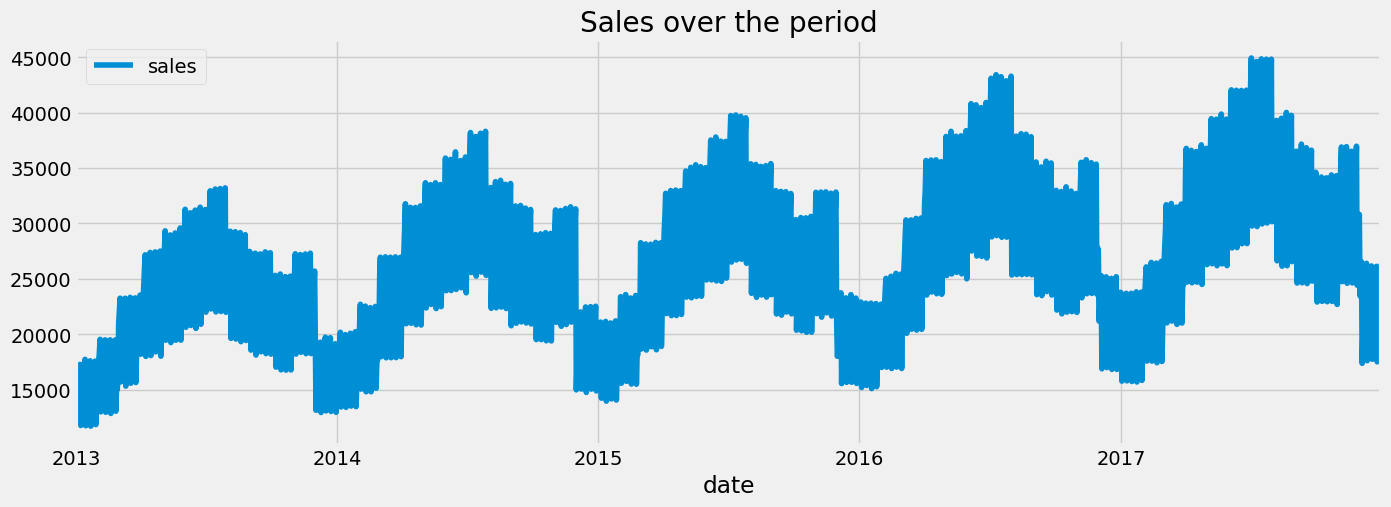

In [59]:
df.plot(
        # style='.',
        figsize=(15, 5),
        color=color_pallet[0],
        title='Sales over the period')
plt.show()

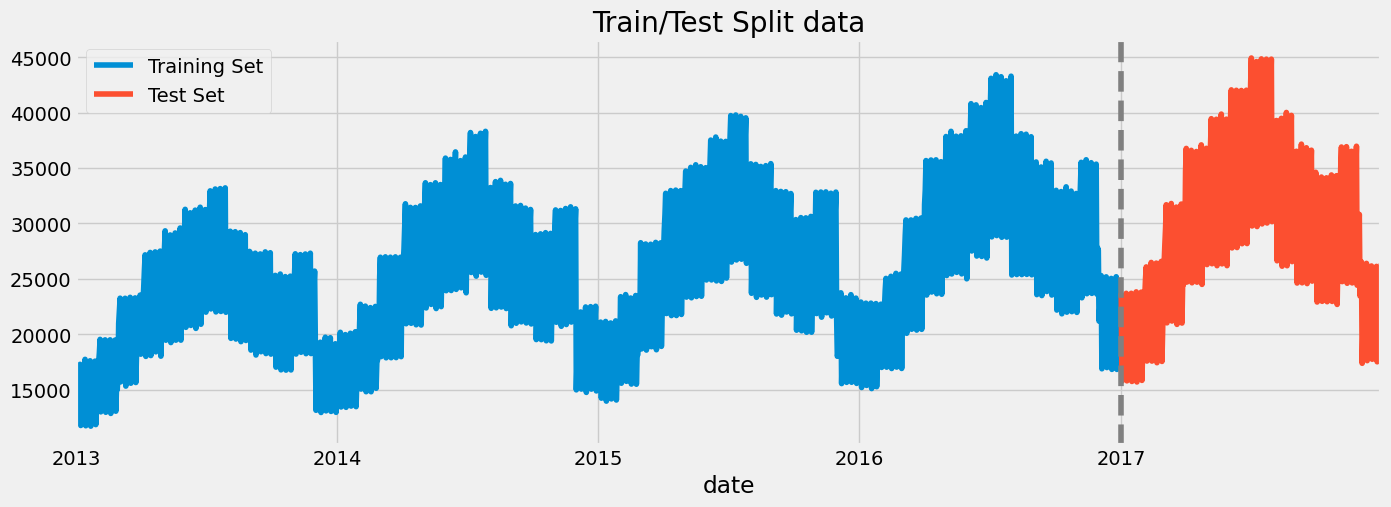

In [60]:
train = df.loc[df.index < '01-01-2017']
test = df.loc[df.index >= '01-01-2017']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split data')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='Gray', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

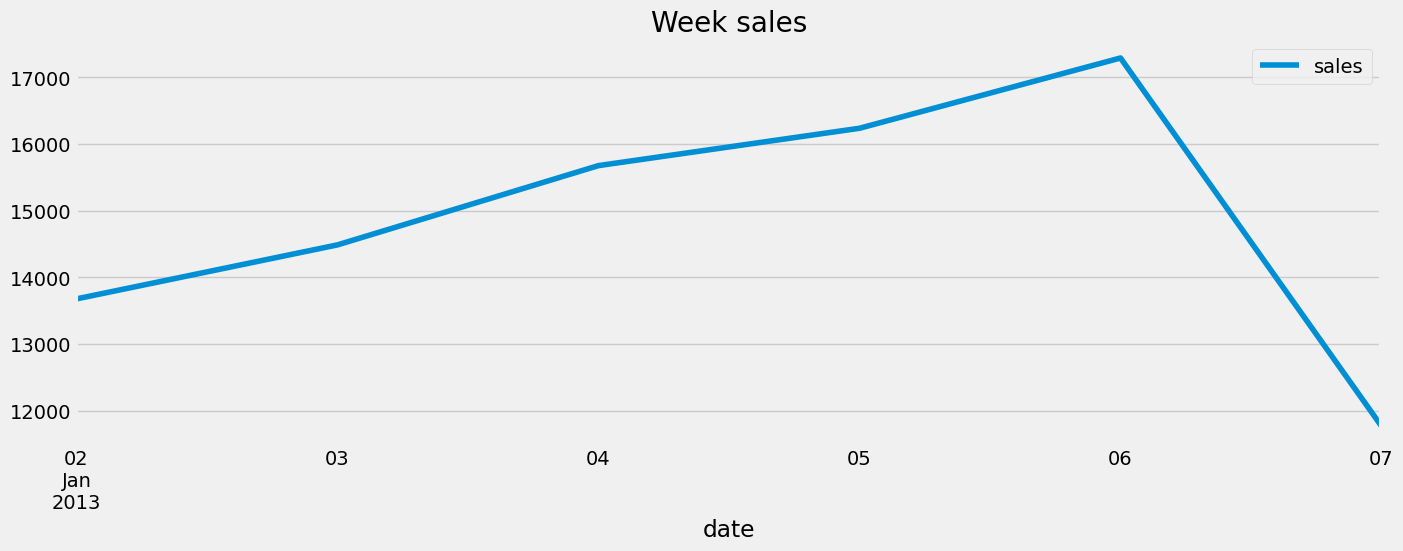

In [61]:
df.loc[(df.index > '01-01-2013') & (df.index < '01-08-2013')] \
    .plot(figsize=(15, 5), title='Week sales')
plt.show()

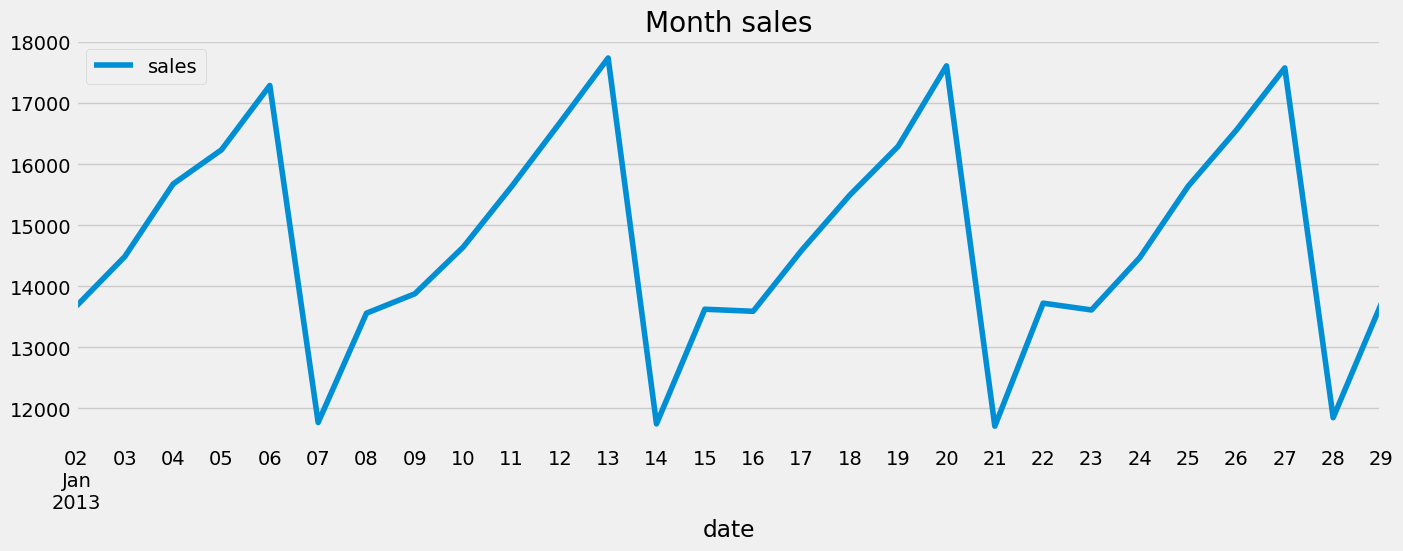

In [62]:
df.loc[(df.index > '01-01-2013') & (df.index < '01-30-2013')] \
    .plot(figsize=(15, 5), title='Month sales')
plt.show()

In [63]:
def create_features(df):
    """
    Creating time series features based on dataframe index.
    """
    df = df.copy()
    # df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

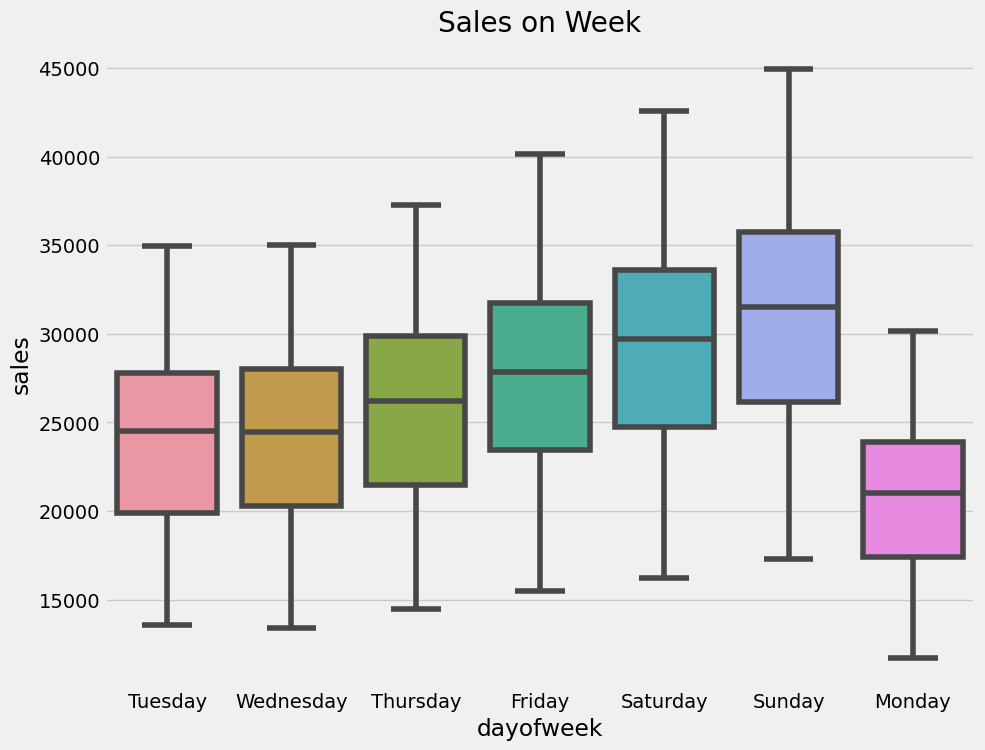

In [64]:
week_day_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}
df_temp = df.copy()
df_temp['dayofweek'] = df_temp['dayofweek'].map(lambda index: week_day_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='dayofweek', y='sales')
ax.set_title('Sales on Week')
plt.show()

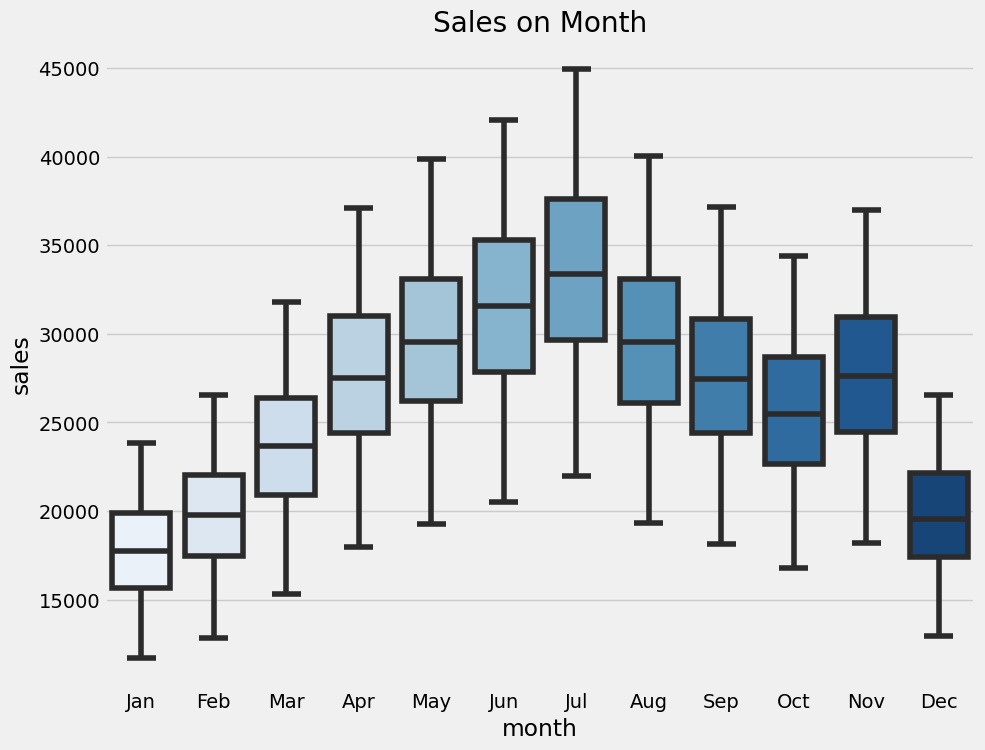

In [65]:
month_map = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}
df_temp = df.copy()
df_temp['month'] = df_temp['month'].map(lambda index: month_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='month', y='sales', palette='Blues')
ax.set_title('Sales on Month')
plt.show()

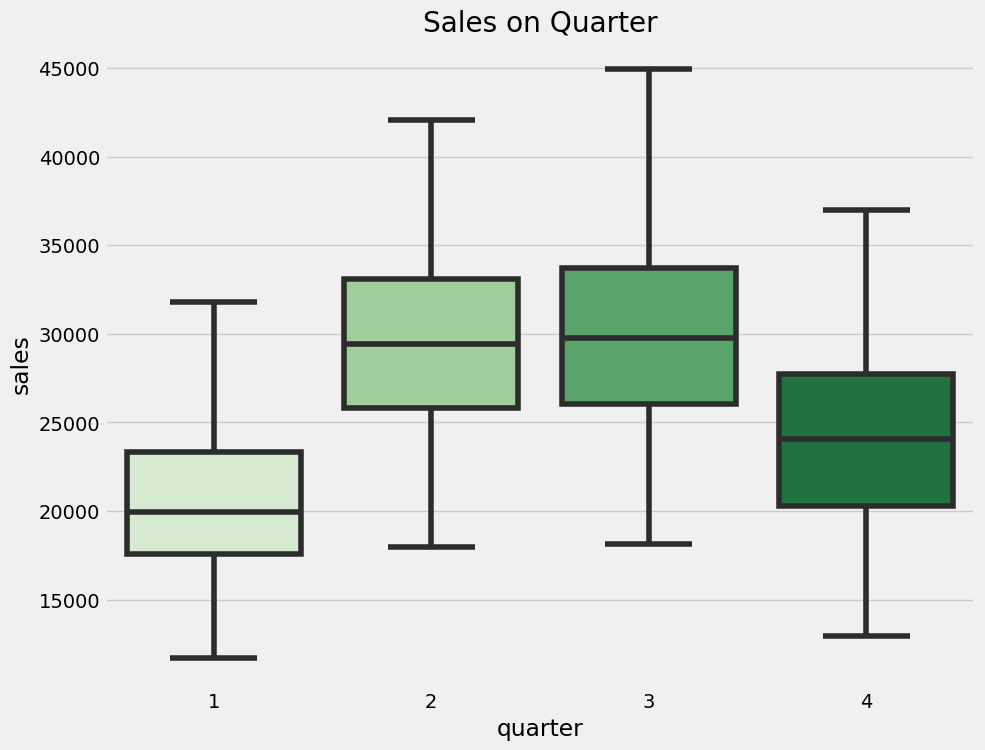

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='quarter', y='sales', palette='Greens')
ax.set_title('Sales on Quarter')
plt.show()

In [67]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [68]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

LinearRegression()

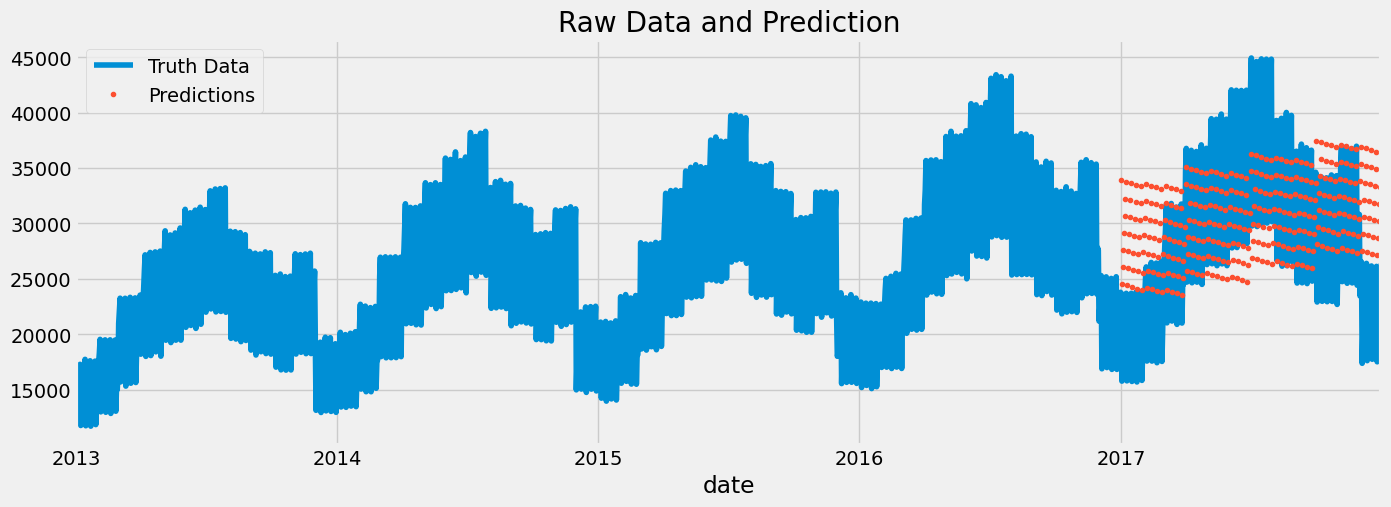

In [69]:
test['prediction_lr'] = linreg_model.predict(X_test)
df = df.merge(test[['prediction_lr']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_lr'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [70]:
linreg_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_lr']))
linreg_mae = mean_absolute_error(test['sales'], test['prediction_lr'])
linreg_r2 = r2_score(test['sales'], test['prediction_lr'])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  5346.264427842598
Linear Regression MAE:  4314.275653544827
Linear Regression R2 Score:  0.3245413312547959


In [86]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

c:\Users\bhowm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.810e+09, tolerance: 5.482e+06
  model = cd_fast.enet_coordinate_descent(


Lasso()

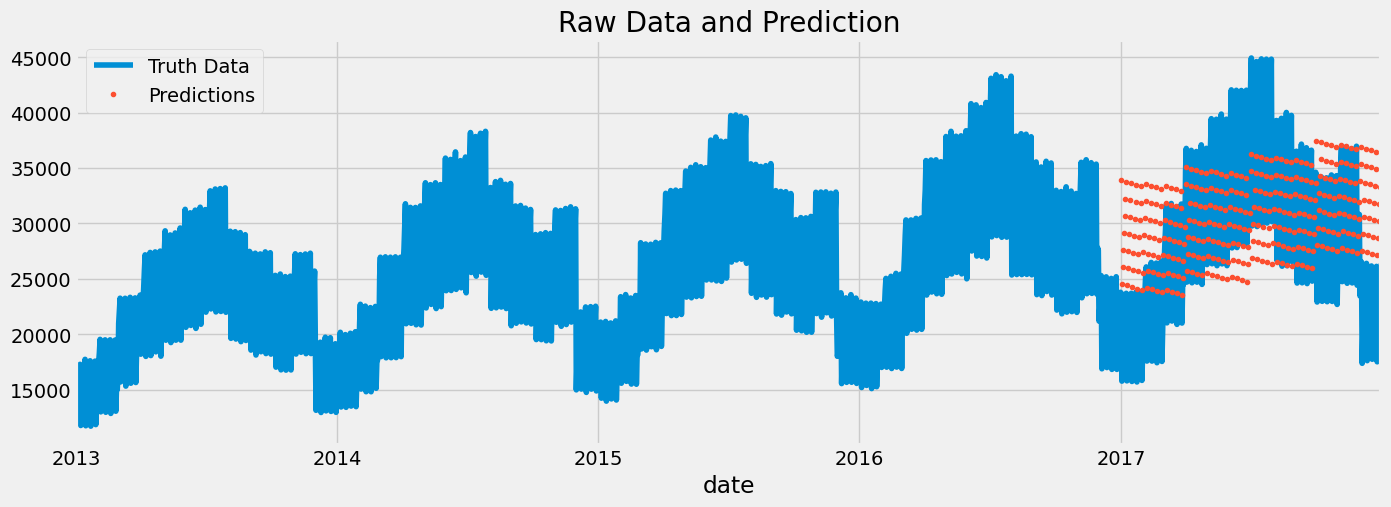

In [87]:
test['prediction_la'] = lasso_model.predict(X_test)
df = df.merge(test[['prediction_la']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_la'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [88]:
la_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_la']))
la_mae = mean_absolute_error(test['sales'], test['prediction_la'])
la_r2 = r2_score(test['sales'], test['prediction_la'])
print('Linear Regression RMSE: ', la_rmse)
print('Linear Regression MAE: ', la_mae)
print('Linear Regression R2 Score: ', la_r2)

Linear Regression RMSE:  5345.916368361414
Linear Regression MAE:  4314.187177620875
Linear Regression R2 Score:  0.32462927757473214


In [93]:
ridge_model =  Ridge()
ridge_model.fit(X_train, y_train)

Ridge()

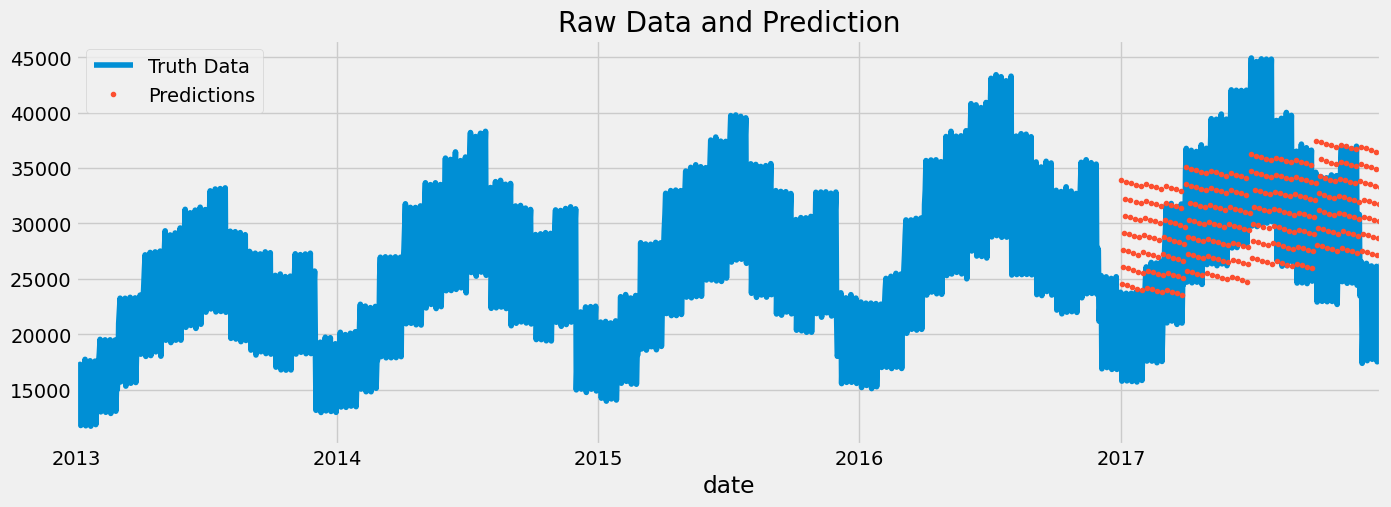

In [94]:
test['prediction_rd'] = ridge_model.predict(X_test)
df = df.merge(test[['prediction_rd']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_rd'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [95]:
rd_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_rd']))
rd_mae = mean_absolute_error(test['sales'], test['prediction_rd'])
rd_r2 = r2_score(test['sales'], test['prediction_rd'])
print('Linear Regression RMSE: ', rd_rmse)
print('Linear Regression MAE: ', rd_mae)
print('Linear Regression R2 Score: ', rd_r2)

Linear Regression RMSE:  5345.81802132979
Linear Regression MAE:  4314.2029248346
Linear Regression R2 Score:  0.324654126483791


In [71]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20)

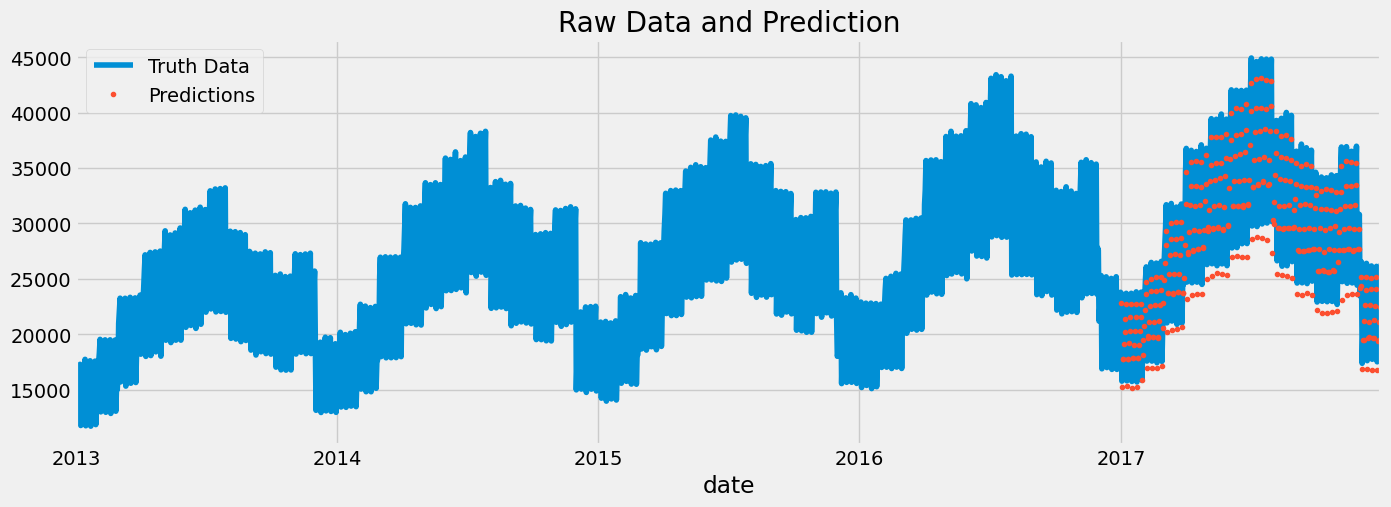

In [72]:
test['prediction_rf'] = rf_model.predict(X_test)
df = df.merge(test[['prediction_rf']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_rf'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [73]:
rf_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_rf']))
rf_mae = mean_absolute_error(test['sales'], test['prediction_rf'])
rf_r2 = r2_score(test['sales'], test['prediction_rf'])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

Random Forest RMSE:  1221.9030379687501
Random Forest MAE:  1141.2796712328768
Random Forest R2 Score:  0.9647165211869324


In [74]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[22:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:25781.11056	validation_1-rmse:29862.55802
[100]	validation_0-rmse:9897.87720	validation_1-rmse:13274.18406
[200]	validation_0-rmse:4177.89475	validation_1-rmse:6517.88338
[300]	validation_0-rmse:2101.67242	validation_1-rmse:3841.10162
[400]	validation_0-rmse:1294.72473	validation_1-rmse:2647.11584
[500]	validation_0-rmse:907.44465	validation_1-rmse:2058.22142
[600]	validation_0-rmse:670.69706	validation_1-rmse:1742.36133
[700]	validation_0-rmse:483.59878	validation_1-rmse:1527.62284
[800]	validation_0-rmse:366.45311	validation_1-rmse:1401.71649
[900]	validation_0-rmse:298.34850	validation_1-rmse:1328.47304
[999]	validation_0-rmse:262.89210	validation_1-rmse:1283.85660


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

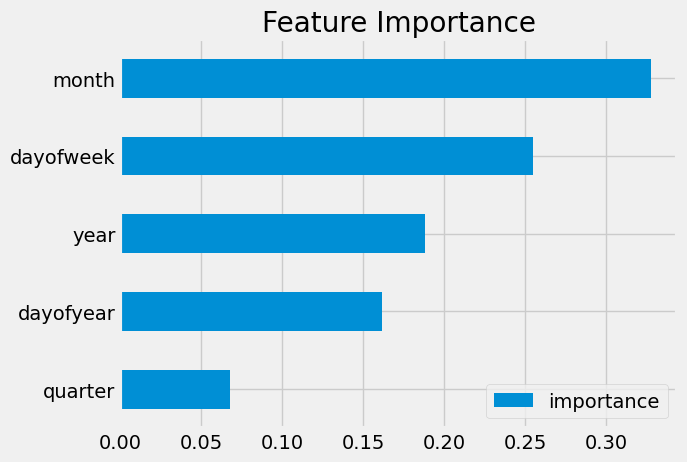

In [75]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

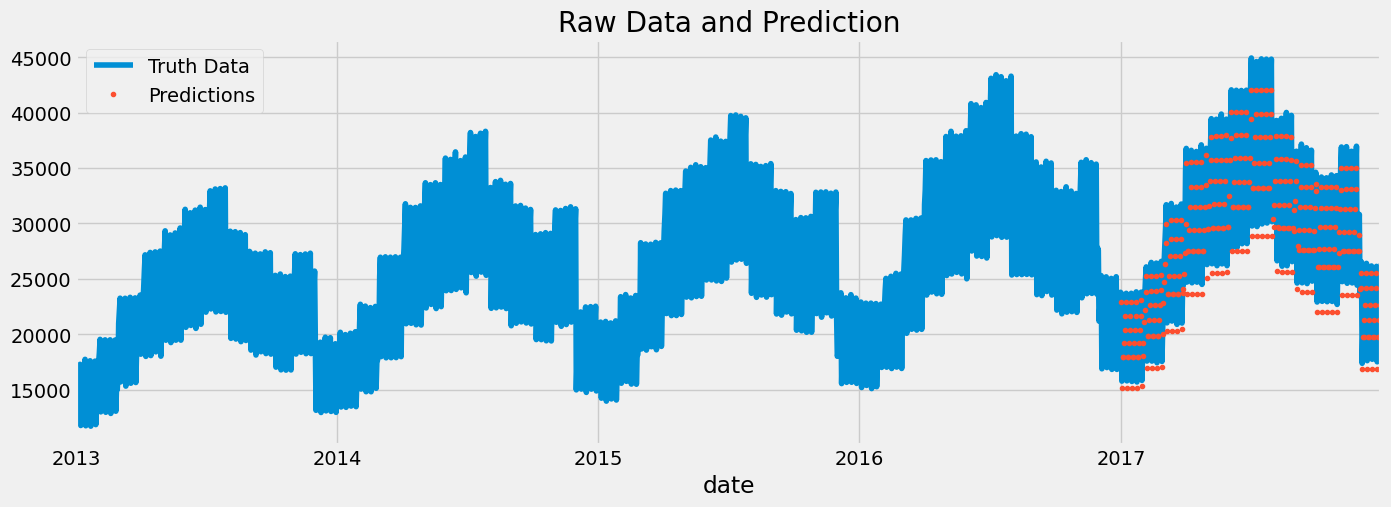

In [76]:
test['prediction_xg'] = reg.predict(X_test)
df = df.merge(test[['prediction_xg']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_xg'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

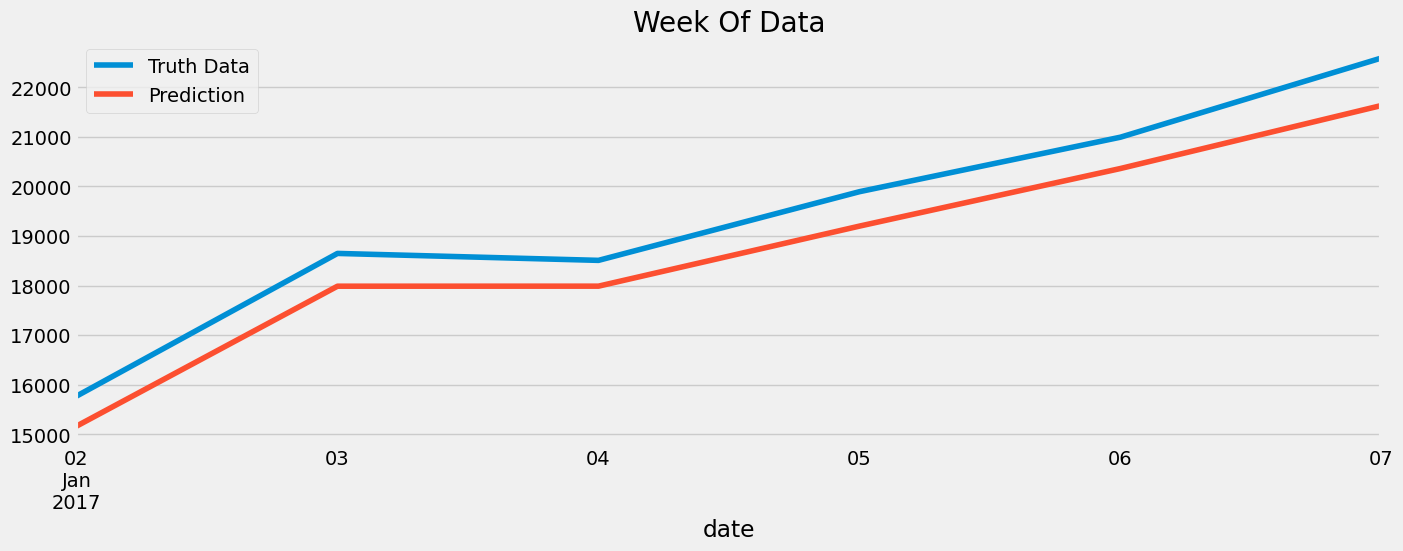

In [77]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['sales'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['prediction_xg'] \
    .plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

In [78]:
xg_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_xg']))
xg_mae = mean_absolute_error(test['sales'], test['prediction_xg'])
xg_r2 = r2_score(test['sales'], test['prediction_xg'])
print('Random Forest RMSE: ', xg_rmse)
print('Random Forest MAE: ', xg_mae)
print('Random Forest R2 Score: ', xg_r2)

Random Forest RMSE:  1283.8566006949254
Random Forest MAE:  1165.1742241010274
Random Forest R2 Score:  0.961047893790965


In [89]:
linreg_stats = [linreg_rmse, linreg_mae, linreg_r2]
rf_stats = [rf_rmse, rf_mae, rf_r2]
xgb_stats = [xg_rmse, xg_mae, xg_r2]
la_stats = [la_rmse, la_mae, la_r2]

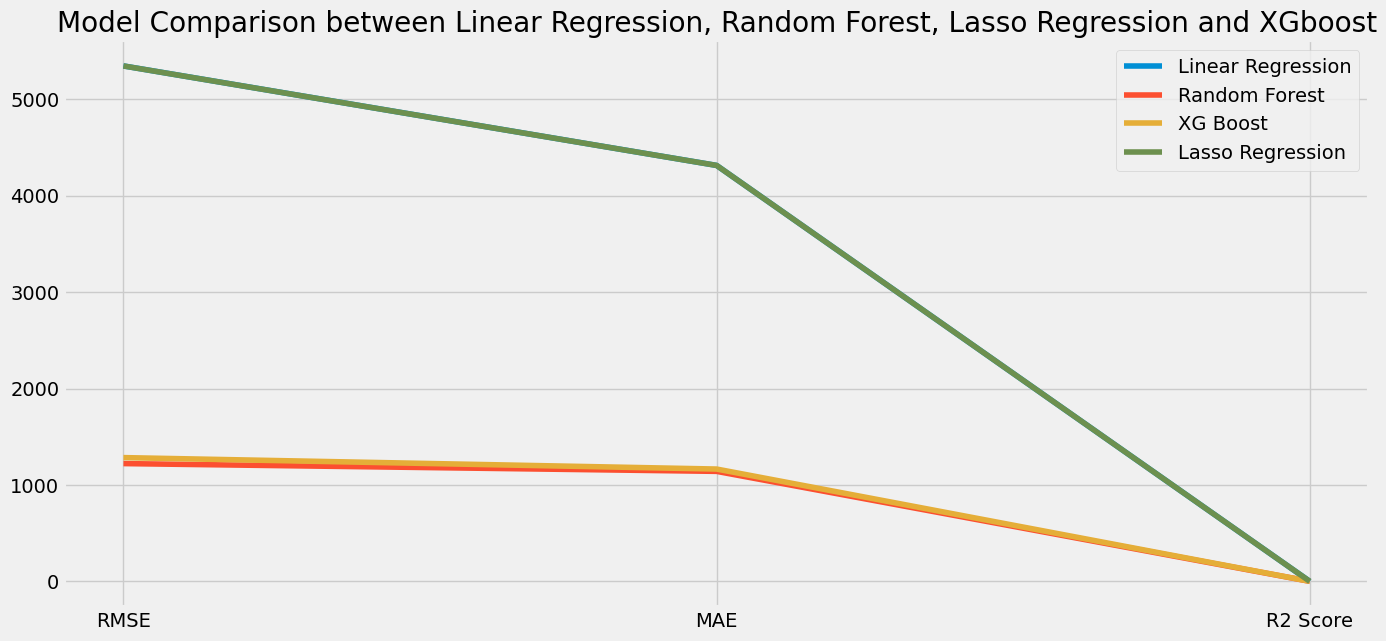

In [90]:
plt.figure(figsize=(15,7))
plt.plot(linreg_stats)
plt.plot(rf_stats)
plt.plot(xgb_stats)
plt.plot(la_stats)
plt.title("Model Comparison between Linear Regression, Random Forest, Lasso Regression and XGboost")
plt.xticks([0,1,2], labels=['RMSE','MAE','R2 Score'])
plt.legend(["Linear Regression", "Random Forest", "XG Boost", "Lasso Regression"])
plt.show()

In [81]:
test['prediction'] = test['prediction_xg']
df['prediction'] = df['prediction_xg']

In [82]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['dates'] = test.index.date

In [83]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-04-01    4793.648438
2017-07-01    3131.398438
2017-07-02    2920.183594
2017-07-16    2840.183594
2017-07-30    2816.183594
2017-07-23    2815.183594
2017-07-22    2626.316406
2017-07-09    2594.183594
2017-06-01    2418.449219
2017-07-15    2283.316406
Name: error, dtype: float64

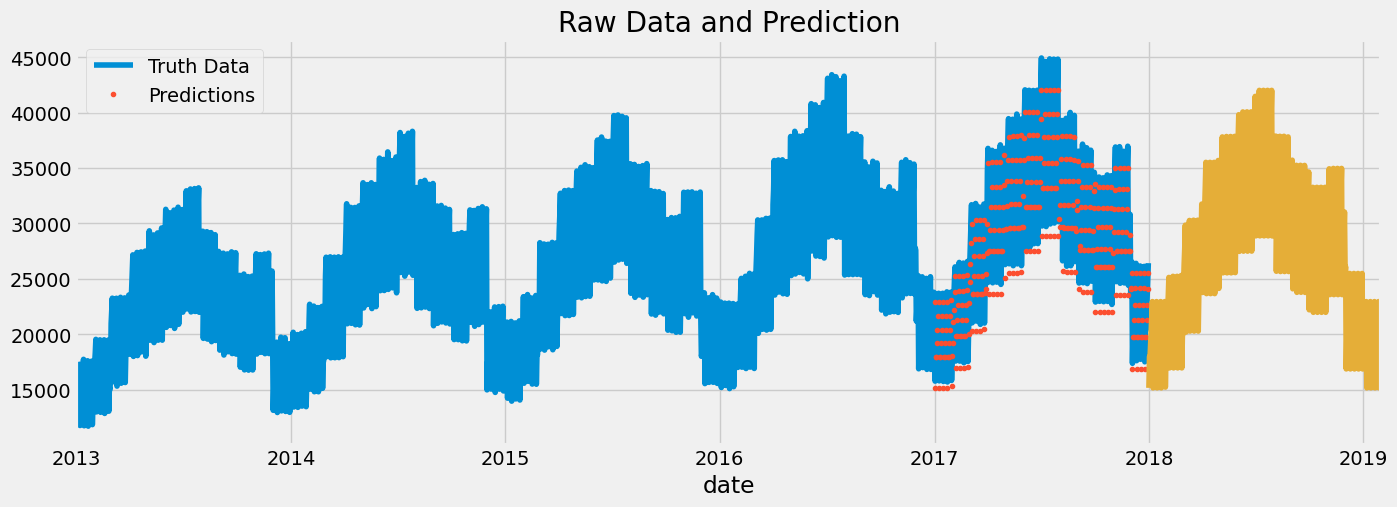

In [84]:
to_predict = pd.DataFrame(pd.date_range(start="2018-01-01", end="2019-02-01"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()


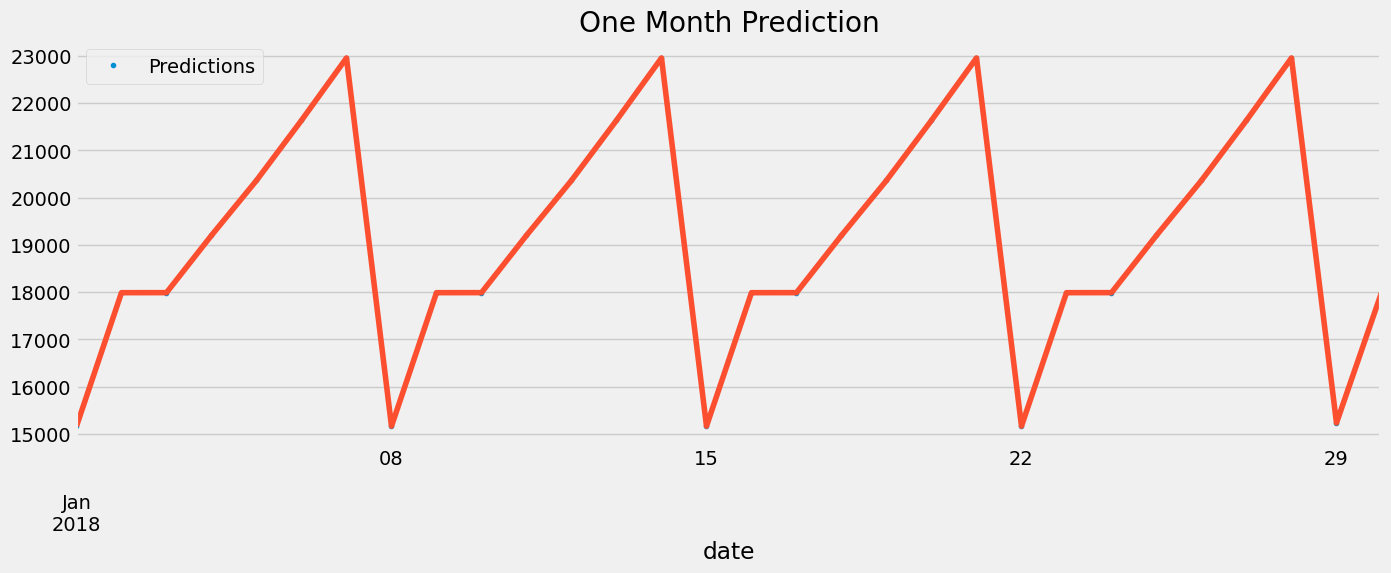

In [85]:
to_predict = pd.DataFrame(pd.date_range(start="2018-01-01", end="2018-01-30"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = to_predict_feature['prediction'].plot(figsize=(15, 5), style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Predictions'])
ax.set_title('One Month Prediction')
plt.show()